<font size="45">Microsoft Movie Studios Analysis</font>

<font size="5">Overview</font>

This project analyses which directors and genres Microsoft Movie Studios should consider when producing movies based on the ratings each recieved. Descriptive analysis of IMDb movie data shows that some directors have higher ratings on their movies compared to others and certain genres also have higher ratings. Microsoft movie studios can use these findings to hire outstandings directors to produce movies that everyone will enjoy.

<font size="5">Business Understanding</font>

Microsoft Movie Studios is looking to start showing orignal movies to beat out all competitors by being the most highly used streaming service. They are willing to do whatever it takes with no limitations in order to acomplish this goal. Using previous IMDb movie data that contains information on genres, directors, average ratings, and number of votes has allowed us to determine a guaranteed path to sucess for Microsoft Movie Studios and what aspects to consider.

<font size="5">Data Understandng</font>

In [2]:
import pandas as pd
import zipfile
import sqlite3 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
with zipfile.ZipFile("../zippedData/im.db") as zip_ref:
    zip_ref.extractall("../zippedData/im.db")

BadZipFile: File is not a zip file

In [13]:
con = sqlite3.connect('../zippedData/im.db')
cursor = con.cursor()

In [30]:
schema_df = pd.read_sql('''
SELECT * 
FROM sqlite_master
''', con)
schema_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [31]:
schema_df['tbl_name']

0     movie_basics
1        directors
2        known_for
3       movie_akas
4    movie_ratings
5          persons
6       principals
7          writers
Name: tbl_name, dtype: object

In [34]:
pd.read_sql('''
SELECT *
FROM movie_basics
JOIN movie_ratings
    ON movie_basics.movie_id = movie_ratings.movie_id
JOIN directors
    ON movie_basics.movie_id = directors.movie_id
JOIN persons
    ON directors.person_id = persons.person_id
''', con)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes,movie_id,person_id,person_id,primary_name,birth_year,death_year,primary_profession
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77,tt0063540,nm0712540,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer"
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77,tt0063540,nm0712540,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer"
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77,tt0063540,nm0712540,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer"
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77,tt0063540,nm0712540,nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer"
4,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43,tt0066787,nm0002411,nm0002411,Mani Kaul,1944.0,2011.0,"director,writer,actor"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181382,tt9914642,Albatross,Albatross,2017,NaN,Documentary,tt9914642,8.5,8,tt9914642,nm5300859,nm5300859,Chris Jordan,NaN,NaN,"director,writer,editor"
181383,tt9914642,Albatross,Albatross,2017,NaN,Documentary,tt9914642,8.5,8,tt9914642,nm5300859,nm5300859,Chris Jordan,NaN,NaN,"director,writer,editor"
181384,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,tt9914942,6.6,5,tt9914942,nm1716653,nm1716653,Laura Jou,NaN,NaN,"miscellaneous,actress,director"
181385,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,tt9914942,6.6,5,tt9914942,nm1716653,nm1716653,Laura Jou,NaN,NaN,"miscellaneous,actress,director"


<font size="5">Data Preparation </font>

### Data Cleaning

The IMDb movie data is being cleaned to get rid of any null values, while keepings only the relevant information needed so that the dataset is less challenging to work with. 

<font size="2">Director information</font>

In [14]:
filteredDirectors = pd.read_sql("""
SELECT p.primary_name AS name,
    AVG(mr.averagerating) as averageRating,
    COUNT(mb.movie_id) AS movieCount
FROM movie_basics AS mb
    JOIN movie_ratings AS mr
        ON mr.movie_id = mb.movie_id
    JOIN directors AS d
        ON mr.movie_id = d.movie_id
    JOIN persons AS p
        ON d.person_id = p.person_id
WHERE p.death_year IS NULL
GROUP BY d.person_id
HAVING mr.numvotes > 500
ORDER BY averageRating DESC

""",con)

In [15]:
messyDirectorGenres = pd.read_sql("""

SELECT mb.genres,
    p.primary_name AS directorName
FROM movie_basics AS mb
    JOIN directors AS d
        ON mb.movie_id = d.movie_id
    JOIN persons as p
        ON p.person_id = d.person_id

""",con)

In [16]:
directorGenres = messyDirectorGenres.dropna()

In [17]:
directorGenres['genres'] = directorGenres['genres'].str.split(',')

<ipython-input-17-1c63bab6135f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directorGenres['genres'] = directorGenres['genres'].str.split(',')


In [18]:
directorGenreDict = directorGenres.explode('genres').groupby("directorName")['genres'].agg(['unique']).to_dict()

The dictionary is being turned into a pandas dataframe.

In [19]:
uniqueDirectorGenres = pd.DataFrame.from_dict(data=directorGenreDict)

In [20]:
directordf = filteredDirectors.merge(uniqueDirectorGenres,how='inner',left_on='name',right_on=uniqueDirectorGenres.index)

In [21]:
directordf['genres'] = directordf['unique']
directordf = directordf.drop(labels='unique',axis=1)

The dataframe is being filtered to directors who have producers at least 5 movies.

In [22]:
directordf[directordf['movieCount'] > 4]

,name,averageRating,movieCount,genres
48,Thiagarajan Kumararaja,8.760000,5,"[Action, Crime, Thriller, Drama]"
55,Quentin Tarantino,8.700000,5,"[Drama, Western, Crime, Mystery, Action, Thril..."
81,Rishab Shetty,8.500000,10,"[Romance, Thriller, Comedy, Drama, Family]"
93,Christopher Nolan,8.437500,8,"[Adventure, Drama, Sci-Fi, Action, Thriller, H..."
114,Harry Baweja,8.360000,5,"[Animation, History]"
...,...,...,...,...
8324,Lawrence Kasanoff,2.516667,6,"[Action, Animation, Comedy, Documentary]"
8341,Ryan Travis,2.300000,6,"[Action, Comedy, Sci-Fi]"
8355,Andrew Bellware,2.087500,8,"[Action, Sci-Fi, Thriller]"
8359,Ezio Greggio,1.900000,5,"[Comedy, Family]"


<font size="2">Genre information</font>

In [23]:
uniqueGenreData = pd.read_sql("""

SELECT mr.averagerating AS rating,
    mb.genres,
    mb.primary_title AS title
FROM movie_basics AS mb
    JOIN movie_ratings AS mr
        ON mb.movie_id = mr.movie_id
WHERE numvotes > 500

""",con)

uniqueGenreData['genres'] = uniqueGenreData['genres'].str.split(',')

In [24]:
singleGenreRatings = uniqueGenreData.explode('genres').groupby('genres').agg(['mean'])

In [25]:
singleGenreRatings['averageRating'] = singleGenreRatings[('rating','mean')]
singleGenreRatings = singleGenreRatings.drop(labels=('rating','mean'),axis=1)

In [26]:
singleGenreRatings = singleGenreRatings.sort_values('averageRating',ascending=False)

<font size="5">Data Visualization</font>

This barplot is showing the top 10 directors with the highest movie ratings.

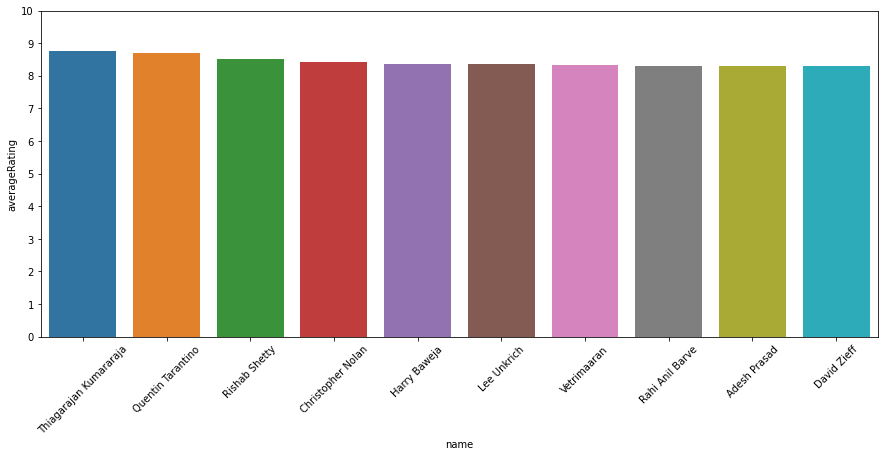

In [27]:
fig,ax = plt.subplots(figsize=(15,6))

sns.barplot(data=directordf[directordf['movieCount'] > 4][:10],x='name',y='averageRating')
plt.xticks(rotation=45);
plt.yticks(range(11));

This barplot is showing the 10 directors with the lowest movie ratings.

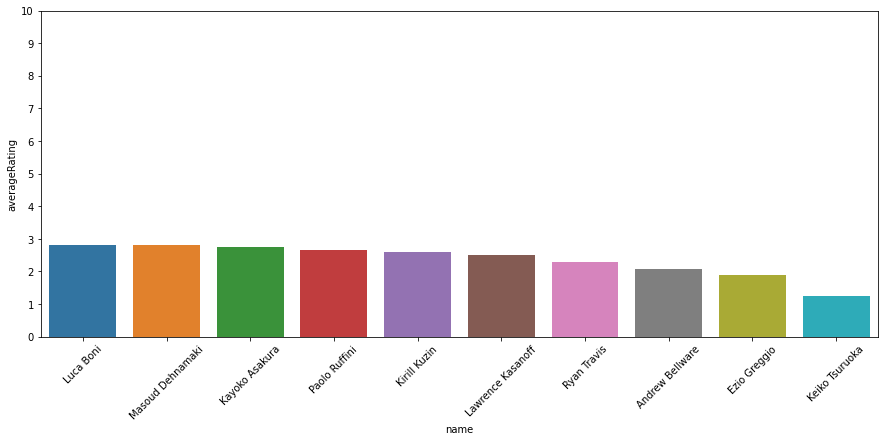

In [28]:
fig,ax = plt.subplots(figsize=(15,6))

sns.barplot(data=directordf[directordf['movieCount'] > 4][-10:],x='name',y='averageRating')
plt.xticks(rotation=45);
plt.yticks(range(11));

This barplot is showing the top 10 genres ratings.

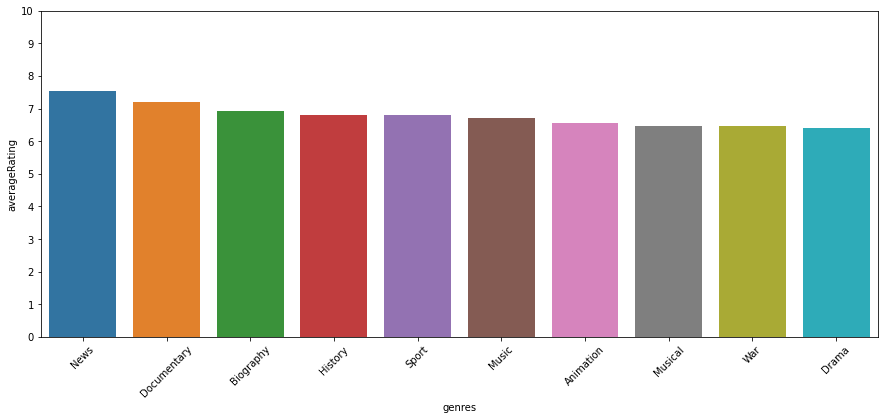

In [29]:
fig,ax = plt.subplots(figsize=(15,6))

sns.barplot(data=singleGenreRatings[:10],x=singleGenreRatings.index[:10],y='averageRating')

plt.xticks(rotation=45);
plt.yticks(range(11));

<font size="5">Conclusion</font>

This Data analysis leads to three recommendations that will allow Microsoft Movie Studios to come out as being the most popular streaming service in business.
- Look to hire directors who have made at least 5 productions that have high ratings. Directors who are dominating in the film industry are more likely to provide you with a well loved movie.
- Focus on streaming orignal movies that are within the most popular genres. Focal point genres that are enjoyed the most are {LIST MOST POPULAR GENRES}
- 


<font size="5">Next Step</font>

Addition analysis 